This notebook is used to create the dataset which will be used for distillation. The input images (RGB + Depth + Normals) are saved. The pipeline developped in `Segment_Anything_Pipeline.ipynb` is used to infer semantic segmentation.

In [5]:
import rosbag
import cv_bridge
from tqdm import tqdm
import cv2
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import csv

from pathlib import Path

from depth.utils import Depth
from data_preparation.create_dataset import (
    get_recursive_bag_files,
    is_bag_healthy,
    get_msg_depth,
)
import params.robot
import params.dataset
from params import PROJECT_PATH

from sam_pipeline_utils import compute_semantic_segmentation, CostType

In [2]:
def input_generator(
    bag_files: list, *, sample_every: int = 1
) -> (np.array, np.array, np.array, Path):
    """
    Generator that yields images, depth and normal images from a list of bag files.

    Args:
        bag_files: list of bag files
        sample_every: sample every n-th image

    Yields:
        image: RGB image
        depth_image: depth image
        normal_image: normal image
        file_name: name of the bag file
    """
    for bag_file in tqdm(get_recursive_bag_files(bag_files)):
        bag = rosbag.Bag(str(bag_file))

        if not is_bag_healthy(bag):
            print(f"File {str(bag_file)} is incomplete. Skipping...")
            continue

        bridge = cv_bridge.CvBridge()
        for i, (_, msg_image, t_image) in enumerate(
            bag.read_messages(topics=[params.robot.IMAGE_TOPIC])
        ):
            if i % sample_every != 0:
                continue

            msg_depth = get_msg_depth(bag, t_image)
            if msg_depth is None:
                continue

            image = bridge.imgmsg_to_cv2(
                msg_image, desired_encoding="passthrough"
            )
            depth_image = bridge.imgmsg_to_cv2(
                msg_depth, desired_encoding="passthrough"
            )

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            depth = Depth(depth_image.copy(), params.dataset.DEPTH_RANGE)
            depth.compute_normal(
                K=params.robot.K,
                bilateral_filter=params.dataset.BILATERAL_FILTER,
                gradient_threshold=params.dataset.GRADIENT_THR,
            )

            depth_image = depth.get_depth(
                fill=True,
                default_depth=params.dataset.DEPTH_RANGE[0],
                convert_range=True,
            )

            normal_image = depth.get_normal(
                fill=True,
                default_normal=params.dataset.DEFAULT_NORMAL,
                convert_range=True,
            )
            normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB)

            yield image, depth_image, normal_image, bag_file

In [3]:
import numpy as np

# I/O


def _save_png(img: np.array, file_path: Path) -> None:
    """
    Save an image as a PNG.
    """
    img = Image.fromarray(img)
    img.save(file_path)

In [11]:
def create_distillation_dataset(
    bag_files: list,
    dataset_dir: Path,
    *,
    should_fill_segmentation: bool = True,
    should_filter_intersection: bool = True,
    cost_type: CostType = CostType.CENTERED,
    completeness_threshold: float = params.dataset.completeness_threshold,
    sample_every: int = 3,
    random_state: int = 42,
) -> None:
    """
    Create a dataset for distillation from a list of bag files.

    Args:
        bag_files: List of bag files to use.
        dataset_dir: Directory to save the dataset in.
        should_fill_segmentation: Whether to fill the holes in the segmentation.
            i.e. the segmentation produced by the mask generator is not complete.
            But for distillation, we might want it to be complete.
            This is done through successive dilations. Defaults to True.
        should_filter_intersection: Whether to filter the intersection of the masks.
            i.e. removes the pixels (for a given mask) that are also in smaller masks.
            Defaults to True.
        cost_type: Cost function used on a mask. i.e. the function that sample patches in the mask
            and averaged their cost. Can be DEFAULT, CENTERED or IQM_CENTERED.
            Defaults to CENTERED.
        completeness_threshold: Threshold of completeness of the segmentation
            (percentage of pixels that are masked) between 0 and 1. Set to 0 to disable.
            Default to params.dataset.completeness_threshold (0.92).
        sample_every: Sample every n-th image. Defaults to 3.
        random_state: Random state for reproducibility. Defaults to 42.
    """
    image_dir = dataset_dir / "images"
    target_dir = dataset_dir / "targets"

    dataset_dir.mkdir(parents=True)
    image_dir.mkdir(parents=True)
    target_dir.mkdir(parents=True)

    image_idx = 0
    file_name_list = []
    for image, depth, normal, file_name in input_generator(
        bag_files,
        sample_every=sample_every,
    ):
        target = compute_semantic_segmentation(
            image,
            depth,
            normal,
            should_fill_segmentation=should_fill_segmentation,
            cost_type=cost_type,
            should_filter_intersection=should_filter_intersection,
            completeness_threshold=completeness_threshold,
        )

        if target is None:
            continue

        # XXX: encapsulated in list for csv writer
        file_name_list.append([file_name])

        _save_png(image, image_dir / f"{image_idx:05d}.png")
        _save_png(depth, image_dir / f"{image_idx:05d}d.png")
        _save_png(normal, image_dir / f"{image_idx:05d}n.png")

        np.save(target_dir / f"{image_idx:05d}.npy", target)

        image_idx += 1

    if image_idx == 0:
        raise ValueError("No image was saved. Check your parameters.")

    with open(dataset_dir / "file_names.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(file_name_list)

    train_idx, test_idx = train_test_split(
        np.arange(image_idx),
        train_size=params.learning.TRAIN_SIZE + params.learning.VAL_SIZE,
        random_state=random_state,
    )

    np.save(dataset_dir / "train_idx.npy", train_idx)
    np.save(dataset_dir / "test_idx.npy", test_idx)

## Test

In [6]:
%%script false --no-raise-error

image_idx = "10"
with Image.open(
    PROJECT_PATH / f"bagfiles/images_extracted/{image_idx}.png"
) as img:
    img = np.array(img)

with Image.open(
    PROJECT_PATH / f"bagfiles/images_extracted/{image_idx}d.png"
) as depth:
    depth = np.array(depth)

with Image.open(
    PROJECT_PATH / f"bagfiles/images_extracted/{image_idx}n.png"
) as normal:
    normal = np.array(normal)

seg = compute_semantic_segmentation(
    img,
    depth,
    normal,
    should_fill_segmentation=True,
    cost_type=CostType.CENTERED,
    should_filter_intersection=True,
    completeness_threshold=0.92,
)

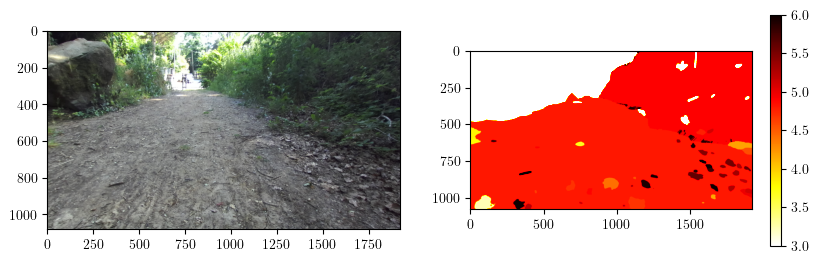

In [7]:
%%script false --no-raise-error

import matplotlib.pyplot as plt

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img)
colorbar = ax2.imshow(seg, cmap="hot_r", vmin=3, vmax=6)
plt.colorbar(colorbar, ax=ax2, shrink=0.6)

In [8]:
%%script false --no-raise-error

# Why is it slow?

%load_ext line_profiler
%lprun -f compute_semantic_segmentation compute_semantic_segmentation( img, depth, normal, should_fill_segmentation=True, cost_type=CostType.CENTERED, should_filter_intersection=True, completeness_threshold=0.92,)

## Dataset creation

In [13]:
name = "dataset_distillation_all"
dataset_dir = PROJECT_PATH / f"datasets/Distillation dataset/{name}"

create_distillation_dataset(
    bag_files=[PROJECT_PATH / "bagfiles/raw_bagfiles/"],
    dataset_dir=dataset_dir,
)

  0%|          | 0/1 [02:36<?, ?it/s]


# Check quality of dataset

In [16]:
import matplotlib.pyplot as plt
from ipywidgets import interact


@interact(id=(0, 4306))
def plot_one_sample(id: int) -> None:
    """
    Plot one sample from the dataset.
    """
    with Image.open(dataset_dir / "images" / f"{id:05d}.png") as img:
        image = np.array(img)
    seg = np.load(dataset_dir / "targets" / f"{id:05d}.npy")

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(image)
    colorbar = ax2.imshow(seg, cmap="hot_r", vmin=2, vmax=6)
    plt.colorbar(colorbar, shrink=0.6)

interactive(children=(IntSlider(value=2153, description='id', max=4306), Output()), _dom_classes=('widget-inte…